## Importing Packages:

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
from jax import jit
from numpyro import sample, deterministic
import warnings
from itertools import product
import pandas as pd
from matplotlib import MatplotlibDeprecationWarning
from numpy.random import default_rng

warnings.filterwarnings(action="ignore");


In [7]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Data Loading & Preprocessing:

In [3]:
# load data:
data = pd.read_csv('data/anemones.csv')

In [4]:
data.shape

(231, 3)

In [6]:
data.head()

,x,y,marks
0,27,7,6
1,197,5,4
2,74,15,4
3,214,18,6
4,121,22,3


## Visualizing Data:


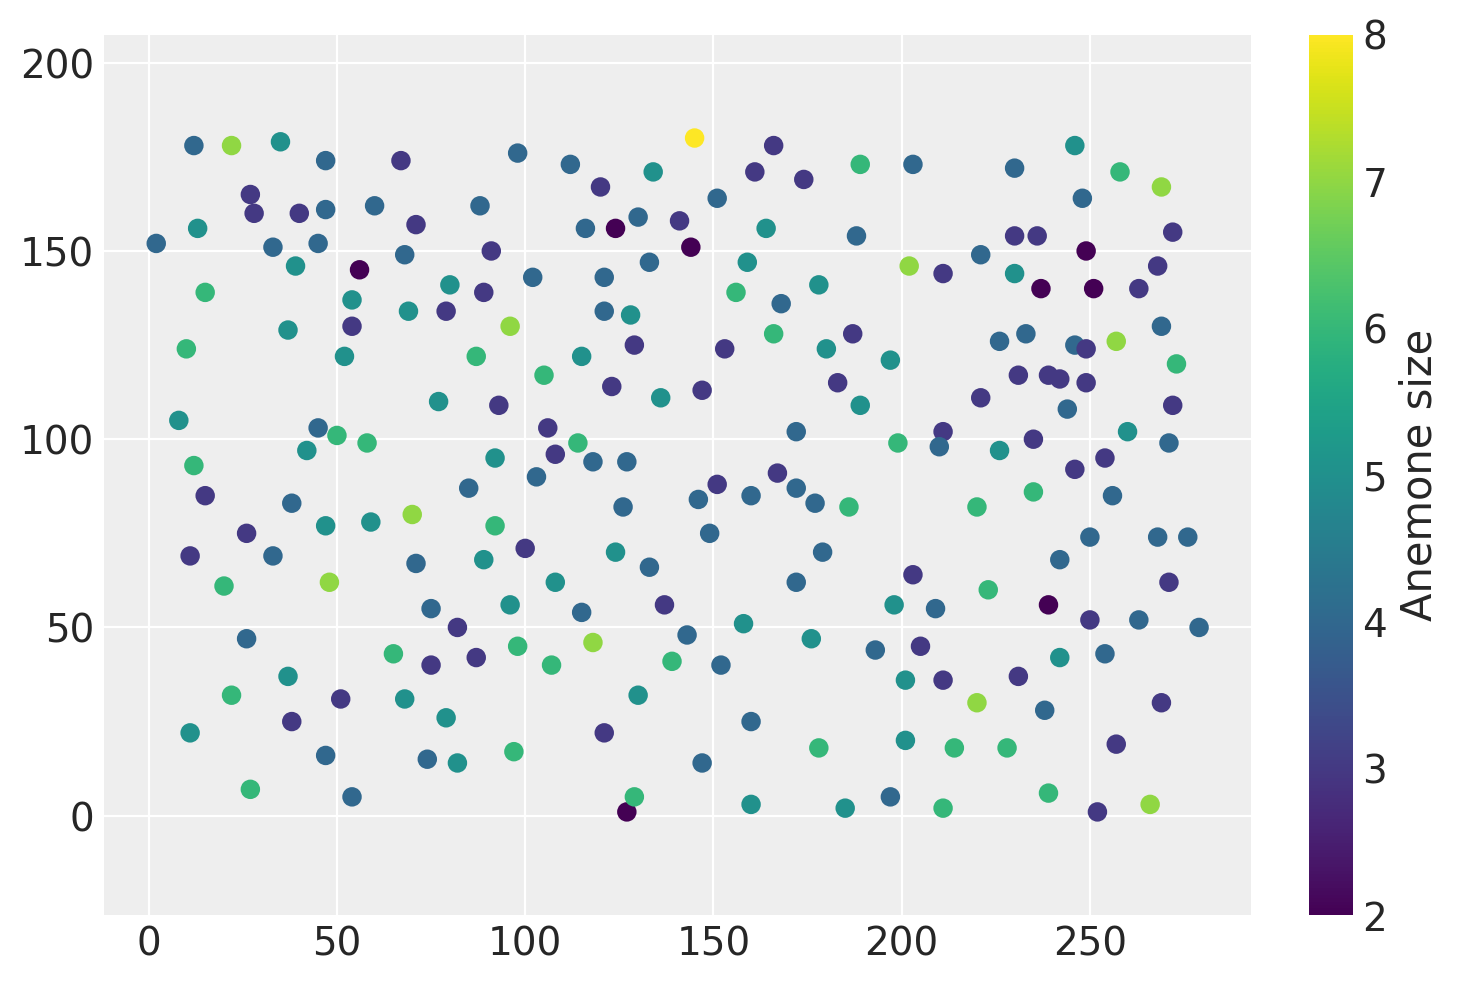

In [8]:
plt.scatter(data["x"], data["y"], c=data["marks"])
plt.colorbar(label="Anemone size")
plt.axis("equal");

In [17]:
280/20

14.0

In [22]:
xy = data[["x", "y"]].values

# Jitter the data slightly so that none of the points fall exactly
# on cell boundaries
eps = 1e-3
rng = default_rng()
xy = xy.astype("float") + rng.standard_normal(xy.shape) * eps

resolution = 20

# Rescaling the unit of area so that our parameter estimates
# are easier to read
area_per_cell = resolution**2 / 100

cells_x = int(280 / resolution)
cells_y = int(180 / resolution)

# Creating bin edges for a 2D histogram
quadrat_x = np.linspace(0, 280, cells_x + 1)
quadrat_y = np.linspace(0, 180, cells_y + 1)

# Identifying the midpoints of each grid cell
centroids = np.asarray(list(product(quadrat_x[:-1] + 10, quadrat_y[:-1] + 10)))

cell_counts, _, _ = np.histogram2d(xy[:, 0], xy[:, 1], [quadrat_x, quadrat_y])
cell_counts = cell_counts.ravel().astype(int)

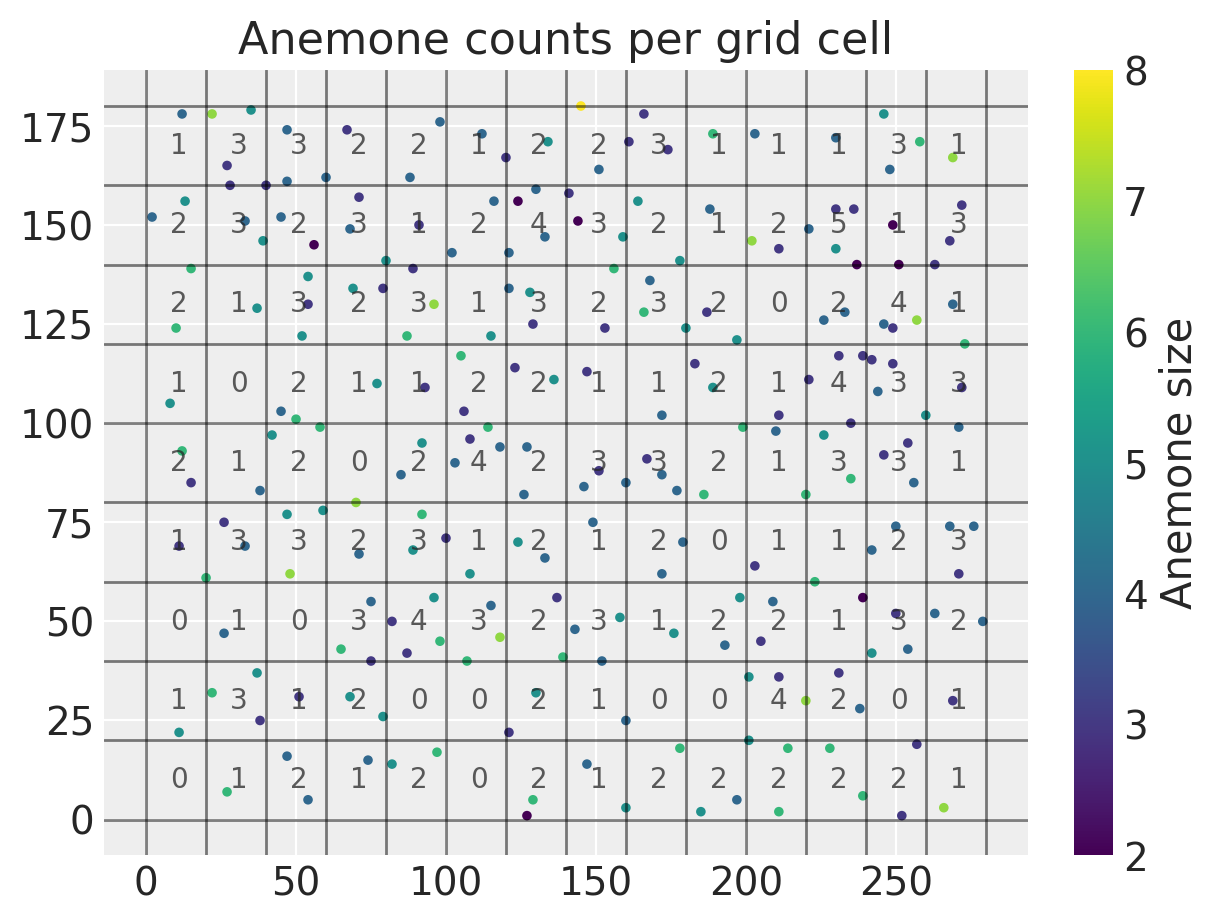

In [23]:
line_kwargs = {"color": "k", "linewidth": 1, "alpha": 0.5}

plt.figure(figsize=(6, 4.5))
[plt.axhline(y, **line_kwargs) for y in quadrat_y]
[plt.axvline(x, **line_kwargs) for x in quadrat_x]
plt.scatter(data["x"], data["y"], c=data["marks"], s=6)

for i, row in enumerate(centroids):
    shifted_row = row - 2
    plt.annotate(cell_counts[i], shifted_row, alpha=0.75)

plt.title("Anemone counts per grid cell"), plt.colorbar(label="Anemone size");

In [11]:
cell_counts

array([0, 1, 0, 2, 2, 1, 2, 2, 1, 1, 3, 1, 2, 1, 0, 1, 2, 5, 2, 1, 0, 3,
       2, 2, 3, 2, 3, 1, 2, 3, 2, 0, 1, 2, 3, 1, 2, 0, 4, 3, 2, 1, 3, 1,
       2, 0, 0, 3, 1, 4, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 3, 4, 2, 1, 1, 2,
       1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 4, 1, 2, 2, 3, 2, 0, 2, 0, 2, 2, 3,
       1, 1, 3, 3, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 1, 3, 3, 3, 4, 1, 2, 0,
       3, 2, 3, 3, 3, 2, 3, 1, 1, 2, 3, 1, 3, 1, 3, 1])

## Model Development:

In [12]:
def matern52_kernel(x1, x2, sigma=1.0, lengthscale=1.0):
    """
    compute the Matérn-5/2 kernel matrix between two sets of points

    args:
    - x1 (array): array of shape (n1, d) representing the first set of points
    - x2 (array): array of shape (n2, d) representing the second set of points
    - sigma (float): variance
    - length_scale (float): length-scale

    returns:
    - K (array): kernel matrix of shape (n1, n2)
    """
    dist = jnp.sqrt(jnp.sum((x1[:, None] - x2) ** 2, axis=-1))
    arg = dist / lengthscale
    return sigma**2 * (1 + jnp.sqrt(5) * arg + 5/3 * arg**2) * jnp.exp(-jnp.sqrt(5) * arg)

# compile the kernel function for better performance
matern52_kernel = jit(matern52_kernel)

In [13]:
def constant_mean_function(mu):
    """
    defining the constant mean function to be used in the lgcp model
    """
    def mean_func(x):
        return jnp.full(x.shape[:-1] + (1,), mu)
    return mean_func

In [24]:
# defining the LGCP model in Numpyro:

def lgcp_model(x = centroids):
    # Prior for mean
    mu = sample("mu", dist.Normal(0, 3))
    # Prior for length scale
    rho = sample("rho", dist.Uniform(25, 300))
    # Prior for variance using InverseGamma directly
    variance = sample("variance", dist.InverseGamma(1.0, 1.0))
    # creating covariance function:
    kernel = matern52_kernel(x, x, sigma=2, lengthscale=rho)
    cov_func = variance * kernel
    mean_func = constant_mean_function(mu)

    mean = mean_func(x)

    log_intensity = sample("log_intensity", 
                           dist.MultivariateNormal(
                               loc=mean, covariance_matrix=cov_func
                               ))
    
    # Intensity and Poisson likelihood
    intensity = jnp.exp(log_intensity)
    rates = intensity * area_per_cell

    with numpyro.plate("observations", len(cell_counts)):
        sample("counts", 
               dist.Poisson(rates), 
               obs=cell_counts)



In [29]:
# MCMC sampling
kernel = NUTS(lgcp_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000)

In [30]:
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key)

sample:  84%|████████▍ | 1680/2000 [1:14:04<15:36,  2.93s/it, 255 steps of size 4.04e-02. acc. prob=0.76]

: 

In [ ]:
# get the posterior samples
posterior_samples = mcmc.get_samples()

# print summary statistics of posterior
# mcmc.print_summary() ## commented this out due to lengthy output

In [60]:

for var in ["mu", "rho"]:
    print(f"{var} - Mean: {posterior_samples[var].mean()}, Std: {posterior_samples[var].std()}")


mu - Mean: -0.8041478395462036, Std: 0.007451367098838091
rho - Mean: 29.53569793701172, Std: 1.3656210899353027


In [19]:
# Creating an ArviZ InferenceData object
inference_data = az.from_numpyro(mcmc)

# Get summary for specific parameters
summary = az.summary(inference_data, var_names=['mu', 'rho', 'variance']);

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [20]:
print(summary)

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu        -0.804  0.007  -0.818   -0.791      0.000    0.000     497.0   
rho       29.536  1.366  27.159   31.978      0.502    0.373       8.0   
variance   0.007  0.000   0.006    0.008      0.000    0.000     129.0   

          ess_tail  r_hat  
mu           625.0    NaN  
rho           24.0    NaN  
variance     219.0    NaN  


In [22]:
# # save mcmc model:

# # Convert to InferenceData
# inference_data = az.from_numpyro(mcmc)

# # Save to NetCDF file
# inference_data.to_netcdf("mcmc_results.nc")


# # #### Load the model
# # loaded_data = az.from_netcdf("mcmc_results.nc")


'mcmc_results.nc'

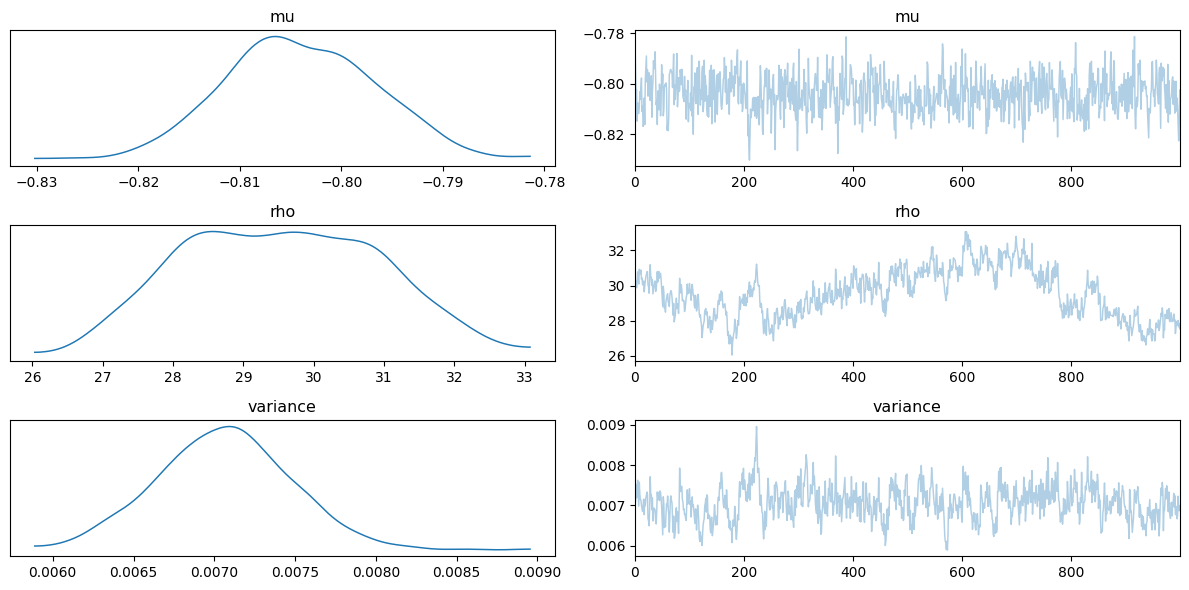

In [24]:
# Plot trace for specific parameters
az.plot_trace(inference_data, var_names=['mu', 'rho', 'variance'])
plt.tight_layout()
plt.show()

### Predictions

In [32]:
# Create new grid points
x_new = jnp.linspace(5, 275, 20)
y_new = jnp.linspace(5, 175, 20)
xs, ys = jnp.meshgrid(x_new, y_new)
xy_new = jnp.stack([xs.ravel(), ys.ravel()], axis=-1)


In [ ]:
# def predictive_model(xy_new):
#     print(f" shape of xy_new : {xy_new.shape}")
#     # Extract parameters from the previous MCMC samples
#     mu = mcmc.get_samples()['mu'][0]
#     print(f"--- mu shape : {mu.shape} ---")
#     rho = mcmc.get_samples()['rho'][0]
#     print(f"--- mu shape : {rho.shape} ---")
#     variance = mcmc.get_samples()['variance'][0]
#     print(f"--- mu shape : {variance.shape} ---")
    
#     # # Recreate the kernel and mean function for new points
#     # def matern52_kernel(x1, x2, sigma, lengthscale):
#     #     # Implement your Matern 5/2 kernel for new points
#     #     # This should be consistent with your original kernel implementation
#     #     dist = jnp.sqrt(jnp.sum((x1[:, None, :] - x2[None, :, :]) ** 2, axis=-1))
#     #     scaled_dist = jnp.sqrt(5) * dist / lengthscale
#     #     kernel = (sigma ** 2) * (1 + scaled_dist + (scaled_dist ** 2) / 3) * jnp.exp(-scaled_dist)
#     #     return kernel
    
#     # def constant_mean_function(mu):
#     #     def mean_func(x):
#     #         return jnp.full(x.shape[:-1] + (1,), mu)
#     #     return mean_func

#     # Compute kernel and mean for new points
#     kernel_new = matern52_kernel(xy_new, xy_new, sigma=2, lengthscale=rho)
#     cov_func_new = variance * kernel_new
#     mean_func_new = constant_mean_function(mu)
#     mean_new = mean_func_new(xy_new)

#     # Sample log intensity for new points
#     log_intensity_new = sample("log_intensity_new", 
#                                 dist.MultivariateNormal(
#                                     loc=mean_new, 
#                                     covariance_matrix=cov_func_new
#                                 ))
#     return log_intensity_new


In [82]:
def predictive_model(xy_new):
    # Get the first sample from each parameter to ensure consistent shapes
    mu = mcmc.get_samples()['mu'][0]  # Take first sample
    rho = mcmc.get_samples()['rho'][0]
    variance = mcmc.get_samples()['variance'][0]
    
    def matern52_kernel(x1, x2, sigma, lengthscale):
        dist = jnp.sqrt(jnp.sum((x1[:, None, :] - x2[None, :, :]) ** 2, axis=-1))
        scaled_dist = jnp.sqrt(5) * dist / lengthscale
        kernel = (sigma ** 2) * (1 + scaled_dist + (scaled_dist ** 2) / 3) * jnp.exp(-scaled_dist)
        return kernel
    
    def constant_mean_function(mu):
        def mean_func(x):
            return jnp.full(x.shape[0], mu)
        return mean_func

    # Compute kernel and mean for new points
    kernel_new = matern52_kernel(xy_new, xy_new, sigma=2, lengthscale=rho)
    cov_func_new = variance * kernel_new
    mean_func_new = constant_mean_function(mu)
    mean_new = mean_func_new(xy_new)

    # Sample log intensity for new points
    log_intensity_new = sample("log_intensity_new", 
                                dist.MultivariateNormal(
                                    loc=mean_new, 
                                    covariance_matrix=cov_func_new
                                ))
    return log_intensity_new


In [83]:

# Creating a Predictive object
rng_key = jax.random.PRNGKey(0)
predictive = Predictive(predictive_model, mcmc.get_samples())

# Sample posterior predictive
posterior_predictive = predictive(rng_key, xy_new=xy_new)

# Extract and convert log intensity to intensity
intensity_samples = jnp.exp(posterior_predictive['log_intensity_new'])

In [84]:
intensity_samples.shape

(1000, 400, 400)

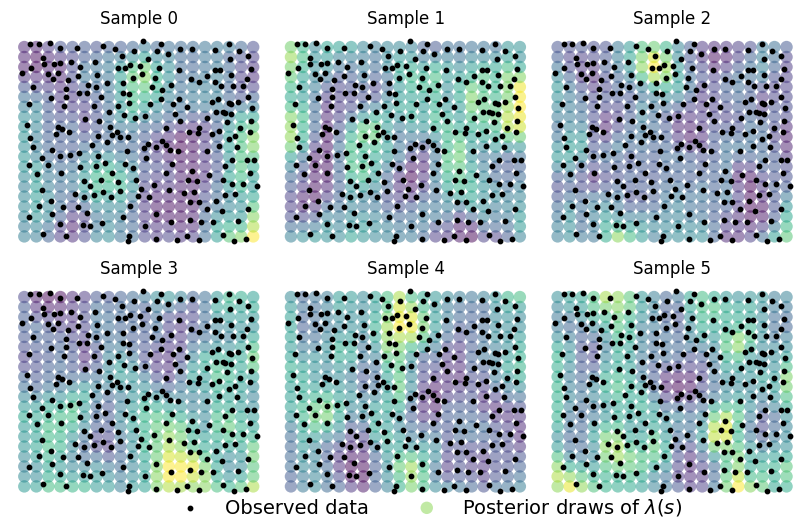

In [76]:
# Converting JAX array to NumPy for plotting
intensity_samples_np = np.array(intensity_samples)

fig, axes = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
axes = axes.ravel()

field_kwargs = {"marker": "o", "edgecolor": "None", "alpha": 0.5, "s": 80}

for i in range(6):
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], 
        c=intensity_samples_np[i],  # Select the i-th draw
        **field_kwargs
    )

    obs_handle = axes[i].scatter(data["x"], data["y"], s=10, color="k")
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")

plt.figlegend(
    (obs_handle, field_handle),
    ("Observed data", r"Posterior draws of $\lambda(s)$"),
    ncol=2,
    loc=(0.2, -0.01),
    fontsize=14,
    frameon=False
)

plt.show()

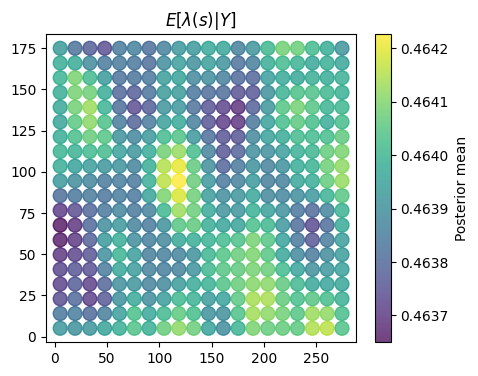

In [85]:
# Convert JAX array to NumPy for plotting
mean_intensity_samples_np = jnp.mean(intensity_samples, axis=(0, 1))

fig = plt.figure(figsize=(5, 4))
plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=mean_intensity_samples_np,
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.title(r"$E[\lambda(s) \vert Y]$")
plt.colorbar(label="Posterior mean")
plt.show()

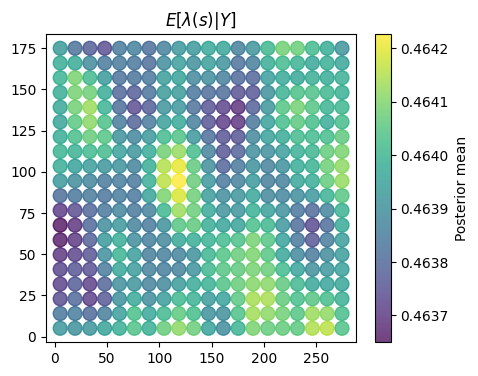

In [86]:
# Convert JAX array to NumPy for plotting
mean_intensity_samples_np = jnp.mean(intensity_samples, axis=(0, 1))

fig = plt.figure(figsize=(5, 4))
plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=mean_intensity_samples_np,
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.title(r"$E[\lambda(s) \vert Y]$")
plt.colorbar(label="Posterior mean")
plt.show()

In [79]:
intensity_samples

Array([[0.51237386, 0.504852  , 0.45445663, ..., 0.4960442 , 0.45885786,
        0.41729385],
       [0.44029248, 0.45907742, 0.47054404, ..., 0.42033523, 0.46850187,
        0.46446517],
       [0.4868792 , 0.51164293, 0.4787053 , ..., 0.4793422 , 0.46952486,
        0.43474698],
       ...,
       [0.47352082, 0.440773  , 0.4629618 , ..., 0.49654198, 0.57724196,
        0.68001044],
       [0.6236746 , 0.6465495 , 0.621314  , ..., 0.39548224, 0.48212832,
        0.45550528],
       [0.4376364 , 0.4973197 , 0.5422828 , ..., 0.39872363, 0.42682543,
        0.47375745]], dtype=float32)